### Define the prerequisite

In [1]:
#
# Copyright 2022-2024 NXP
# All rights reserved.
# 
# SPDX-License-Identifier: BSD-3-Clause
#

import os
import glob
import platform
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from scipy import stats
from pylab import rcParams
from sklearn import metrics
from sklearn.model_selection import train_test_split
from pathlib import Path
import time as time
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, precision_score,classification_report
from collections import Counter
from packaging.version import Version

tf.compat.v1.enable_eager_execution()
#tf.compat.v1.disable_eager_execution()

%matplotlib inline

ML_STATE_MONITOR_ML_APP_VERSION = "2.1.0"

print("ML-app version: " + ML_STATE_MONITOR_ML_APP_VERSION)
print("Python version: " + platform.python_version())
print("TF     version: " + tf.__version__)
print("Keras  version: " + keras.__version__)

if ((Version(tf.__version__) >= Version("2.16")) | (Version(keras.__version__) >= Version("3"))):
    raise Exception("Please use 'Tensorflow < 2.16' and 'Keras < 3' otherwise TFLiteConverter may fail to execute.")

np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# constants
SENSOR_COLLECT_RATE_HZ = 200 # Sampling frequency
SENSOR_ACC_RESOLUTION = 2**13 # signed 14-bit resolution for X-Y-Z axis
RANDOM_SEED = 1
FEED_WINDOW = 128 # window size
FEED_WINDOW_OFST = 64 # window offset
N_CHANNELS = 3 # number of channels
N_CLASSES = 4 # number of classes

RAW_SENSOR_DATA_DIR = "./in_sensor_data"
RAW_SENSOR_DATA_FN = RAW_SENSOR_DATA_DIR + "/" + "in_sensor_data" + ".txt"
RAW_SENSOR_DATA_EXTENSION = "*.csv"
OUT_MODELS_FOLDER = "./models/"

TRAIN_DATA_DIR = RAW_SENSOR_DATA_DIR + "/" + "training"
TEST_DATA_DIR = RAW_SENSOR_DATA_DIR + "/" + "validation"

FILTER_DATASET_EN = 1 # filter corrupted data
FILTER_LABELS = ["FAN-CLOG", "FAN-FRICTION", "FAN-OFF", "FAN-ON"]

# Trian with v1 data
v1_DATA = 0
v1_NORMALIZATION = 0

GENERATE_GLOW_BUNDLE_EN = 1 # generate the glow bundle by executing C:\nxp\Glow\bin\model-compiler.exe
GENERATE_NEUTRON_BUNDLE_EN = 1 # generate the neutron bundle by executing C:\nxp\eIQ_Toolkit_v*\...\neutron-converter.exe

if not os.path.exists(OUT_MODELS_FOLDER):
    os.makedirs(OUT_MODELS_FOLDER)

ML-app version: 2.1.0
Python version: 3.9.13
TF     version: 2.6.0
Keras  version: 2.6.0


# 0) Import the datasets

In [2]:
# Import the raw data
# merge all input files
tr_files = glob.glob(os.path.join(TRAIN_DATA_DIR , "*.csv"))
val_files = glob.glob(os.path.join(TEST_DATA_DIR , "*.csv"))
all_filenames=tr_files+val_files
li = []
for source in [tr_files,val_files]:
    for filename in source:
        df0 = pd.read_csv(filename,on_bad_lines='skip')
        df0['filename']=str(filename).split("\\")[-1][:-4]
        df0['source']=filename.split("/")[-1].split("\\")[0] ## If it is training or validation data
        li.append(df0)

combined_csv = pd.concat(li, axis=0, ignore_index=True)
# filter the input dataset
dataset_size = combined_csv.shape[0]
if FILTER_DATASET_EN:
    # Remove rows that have missing values/fields
    combined_csv.dropna(inplace=True)
    
    # Remove rows that doesn't match the monitored labels
    # combined_csv.drop(combined_csv.index[~combined_csv["class"].isin(FILTER_LABELS)], inplace=True)
    combined_csv = combined_csv[combined_csv['class'].isin(FILTER_LABELS)]
    
    if dataset_size != combined_csv.shape[0]:
        print("\nWARN: Corrupted dataset detected (" + str(dataset_size - combined_csv.shape[0]) + " lines dropped) \n")
        
    dataset_size = combined_csv.shape[0]

# export to csv
if os.path.exists(RAW_SENSOR_DATA_FN):
    os.remove(RAW_SENSOR_DATA_FN)
combined_csv.to_csv(RAW_SENSOR_DATA_FN, index=False, encoding='utf-8-sig')

sns.set(style='whitegrid', palette='muted', font_scale=1.5)
rcParams['figure.figsize'] = 14, 8        
        
# define the format for each instance/row within the input files
if v1_DATA == 1:
    columns = ['class','time[ms]','Ax', 'Ay', 'Az', 'Bx', 'By', 'Bz', 'temp','filename', 'source']    
else:
    columns = ['class','time[ms]','Ax', 'Ay', 'Az','filename', 'source']
    
ds = pd.read_csv(RAW_SENSOR_DATA_FN, header = 0, names = columns)
ds_no_norm = ds.copy()

# extract the labels
classes_name = list(Counter(ds['class']).keys())
    
print("Classes: " + str(classes_name))
print("Full dataset shape: " + str(ds.shape))
ds.head()

Classes: ['FAN-CLOG', 'FAN-FRICTION', 'FAN-OFF', 'FAN-ON']
Full dataset shape: (3840008, 7)


,class,time[ms],Ax,Ay,Az,filename,source
0,FAN-CLOG,5,-134,69,994,200Hz_5Vfan-1-tr-clog,training
1,FAN-CLOG,10,-20,-66,1077,200Hz_5Vfan-1-tr-clog,training
2,FAN-CLOG,15,57,-27,1213,200Hz_5Vfan-1-tr-clog,training
3,FAN-CLOG,20,3,-54,1092,200Hz_5Vfan-1-tr-clog,training
4,FAN-CLOG,25,-111,57,1107,200Hz_5Vfan-1-tr-clog,training


FAN-CLOG        960002
FAN-FRICTION    960002
FAN-OFF         960002
FAN-ON          960002
Name: class, dtype: int64
(3840008, 7)


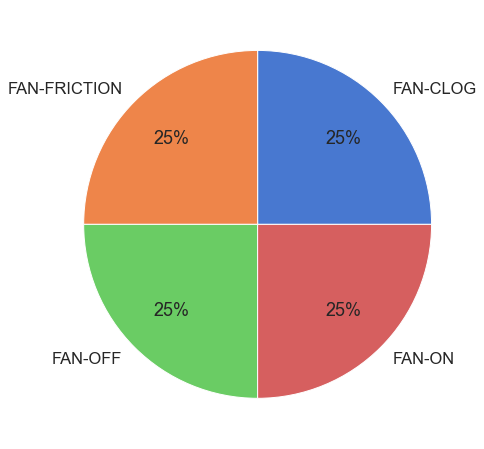

In [3]:
print(ds['class'].value_counts().sort_index())
print(np.shape(ds))
plt.pie(Counter(ds['class']).values(), labels=classes_name, pctdistance=0.7, autopct='%1.f%%')
plt.show()

# 1) Plot and analyze the raw data

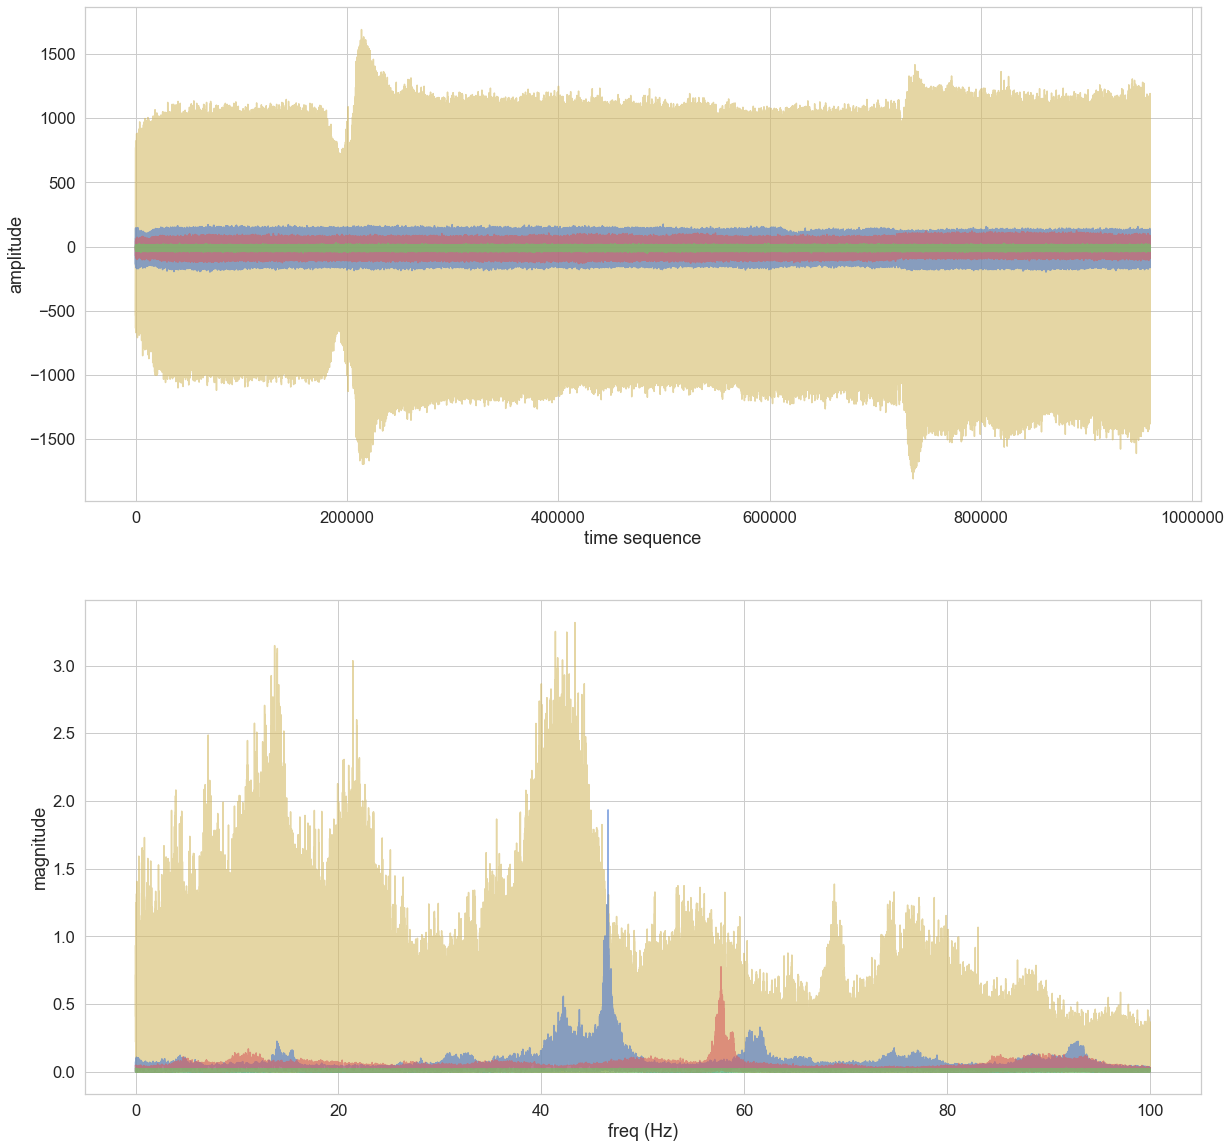

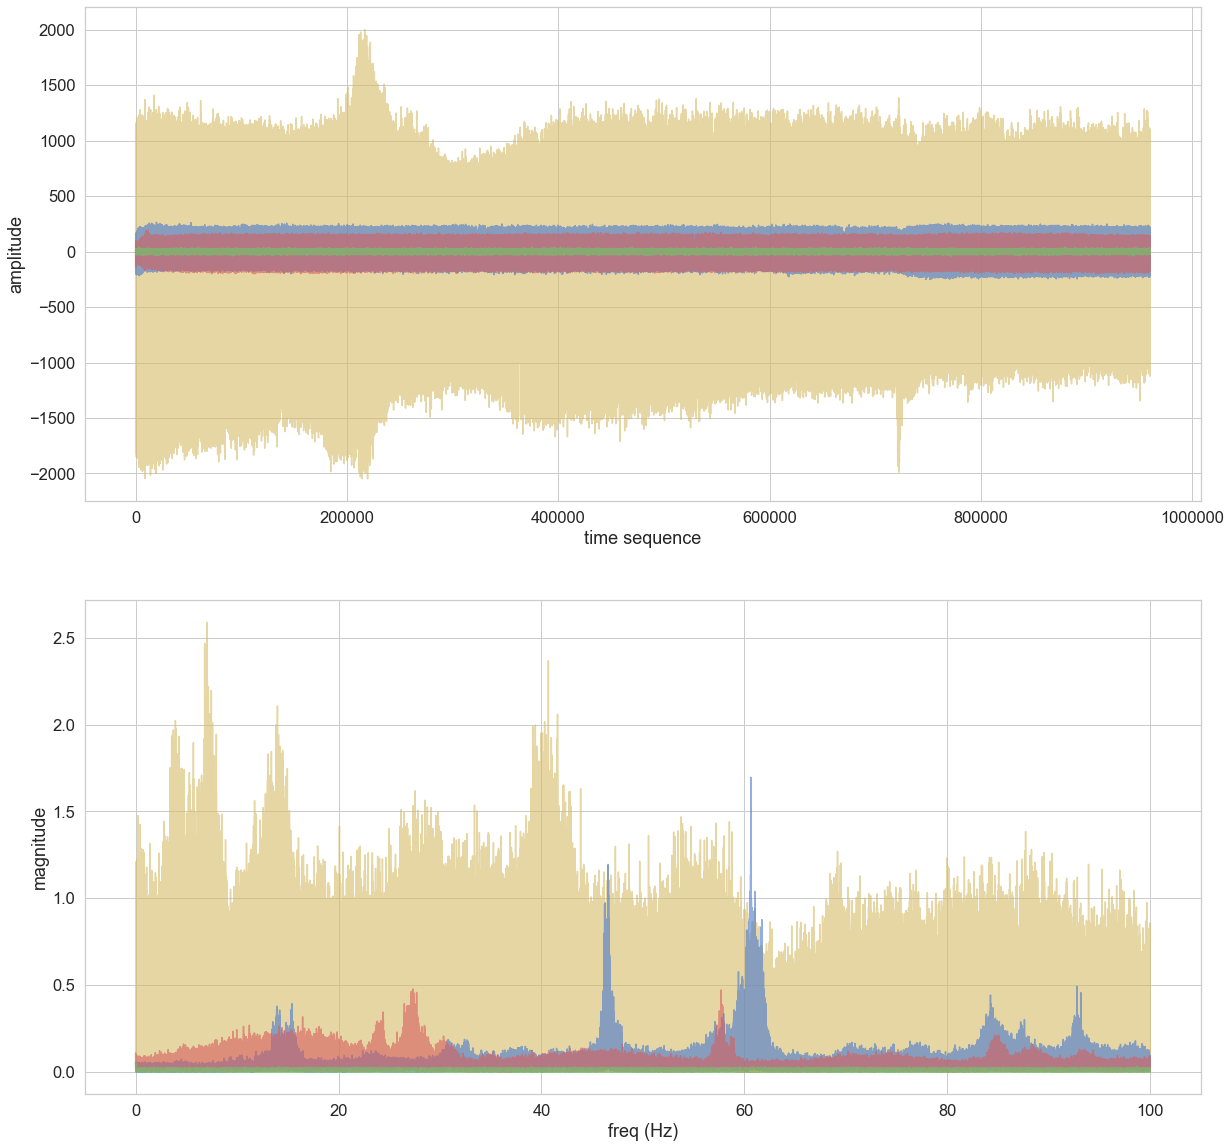

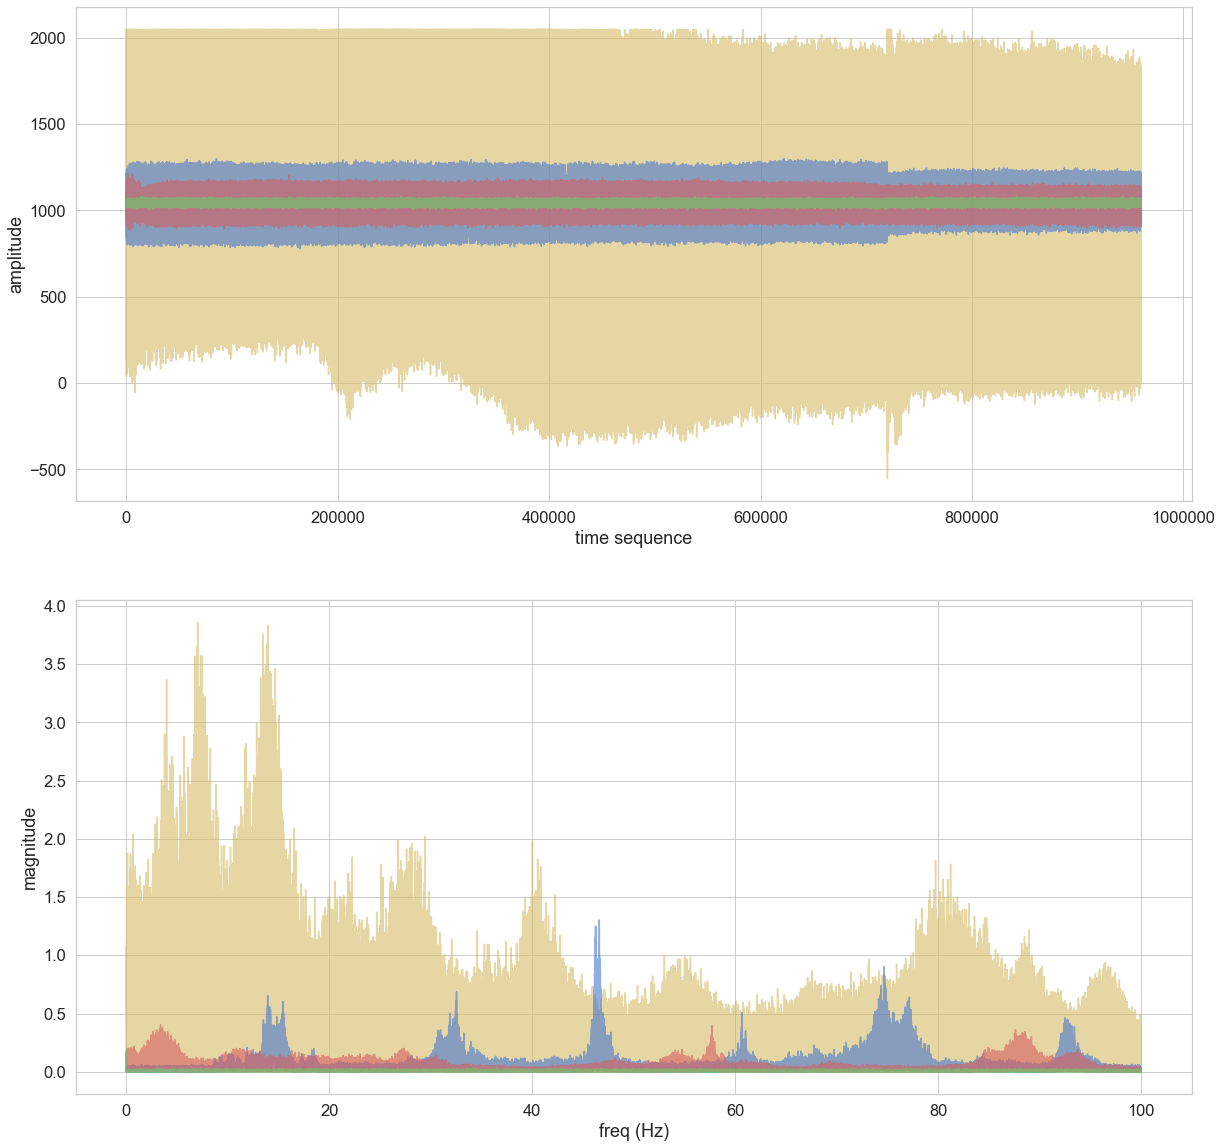

In [4]:
# Plot frequency-domain
def plot_fft_by_class_multiple(signal, lineformat, size):
    from scipy.fft import fft, ifft
    
    # Compute the frequency spectrum
    Y = []
    for insign in signal:
        fft = np.fft.fft(insign)/size
        fft = fft[range(size//2)]
        Y.append(fft)
    freq = ((np.arange(size)*SENSOR_COLLECT_RATE_HZ)/size)[range(size//2)]
    
    plt.figure(figsize=(20, 20))
    plt.subplot(2,1,1)
    for i in range(np.shape(signal)[0]):
        plt.plot(np.arange(0, size), signal[i], lineformat[i], alpha=0.6)
#     plt.ylim(-100, 100)
    plt.xlabel('time sequence')
    plt.ylabel('amplitude')
    plt.ticklabel_format(useOffset=False, style='plain')
    
    plt.subplot(2,1,2)
    for i in range(np.shape(Y)[0]):
        plt.plot(freq[1:], abs(Y[i])[1:], lineformat[i], alpha=0.6)
#     plt.ylim(0, 1)
    plt.xlabel('freq (Hz)')
    plt.ylabel('magnitude')

sz_cls = [sz for sz in ds['class'].value_counts()]
plot_sz = min(sz_cls)
plot_color = ['y-', 'b-', 'r-', 'g-']

signFANCLOG = (ds[ds['class'] == "FAN-CLOG"][['Ax']]).values.reshape(-1)
signFANFRICT = (ds[ds['class'] == "FAN-FRICTION"][['Ax']]).values.reshape(-1)
signFANOFF = (ds[ds['class'] == "FAN-OFF"][['Ax']]).values.reshape(-1)
signFANON = (ds[ds['class'] == "FAN-ON"][['Ax']]).values.reshape(-1)
plot_sign = [signFANFRICT[:plot_sz], signFANCLOG[:plot_sz], signFANON[:plot_sz], signFANOFF[:plot_sz]]
plot_fft_by_class_multiple(plot_sign, plot_color, plot_sz)

signFANCLOG = (ds[ds['class'] == "FAN-CLOG"][['Ay']]).values.reshape(-1)
signFANFRICT = (ds[ds['class'] == "FAN-FRICTION"][['Ay']]).values.reshape(-1)
signFANOFF = (ds[ds['class'] == "FAN-OFF"][['Ay']]).values.reshape(-1)
signFANON = (ds[ds['class'] == "FAN-ON"][['Ay']]).values.reshape(-1)
plot_sign = [signFANFRICT[:plot_sz], signFANCLOG[:plot_sz], signFANON[:plot_sz], signFANOFF[:plot_sz]]
plot_fft_by_class_multiple(plot_sign, plot_color, plot_sz)

signFANCLOG = (ds[ds['class'] == "FAN-CLOG"][['Az']]).values.reshape(-1)
signFANFRICT = (ds[ds['class'] == "FAN-FRICTION"][['Az']]).values.reshape(-1)
signFANOFF = (ds[ds['class'] == "FAN-OFF"][['Az']]).values.reshape(-1)
signFANON = (ds[ds['class'] == "FAN-ON"][['Az']]).values.reshape(-1)
plot_sign = [signFANFRICT[:plot_sz], signFANCLOG[:plot_sz], signFANON[:plot_sz], signFANOFF[:plot_sz]]
plot_fft_by_class_multiple(plot_sign, plot_color, plot_sz)

In [5]:
# Plot time-domain
def plot_all(ds):
    data = ds[['Ax', 'Ay', 'Az']]
    axis = data.plot(subplots=True, figsize=(15, 10), title='All classes')
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
        ax.ticklabel_format(useOffset=False, style='plain')
        
def plot_class(classes, ds):
    title = ' '
    data = []
    for class_name in classes:
        class_data = ds[ds['class'] == class_name][['Ax', 'Ay', 'Az']]
        data.append(class_data)
        title = title + class_name + ' '
    data = pd.concat(data)
    axis = data.plot(subplots=True, figsize=(15, 10), title=title)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
        ax.ticklabel_format(useOffset=False, style='plain')
        
def plot_class_interval(class_name, ds, ist, isp):
    from matplotlib.ticker import (AutoMinorLocator, MultipleLocator)
    data = ds[ds['class'] == class_name][['Ax', 'Ay', 'Az']][ist:isp]
    axis = data.plot(subplots=True, figsize=(15, 10), title=class_name)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
        ax.ticklabel_format(useOffset=False, style='plain')
        
        # Change major ticks to show every 20
        ax.xaxis.set_major_locator(MultipleLocator(20))
        ax.yaxis.set_major_locator(MultipleLocator(20))

        # Change minor ticks to show every 2 (20/10 = 2)
        ax.xaxis.set_minor_locator(AutoMinorLocator(10))
        ax.yaxis.set_minor_locator(AutoMinorLocator(10))
        
        # Turn grid on for major and minor ticks
        ax.grid(which='major', color='#CCCCCC', linestyle='--')
        ax.grid(which='minor', color='#CCCCCC', linestyle=':')

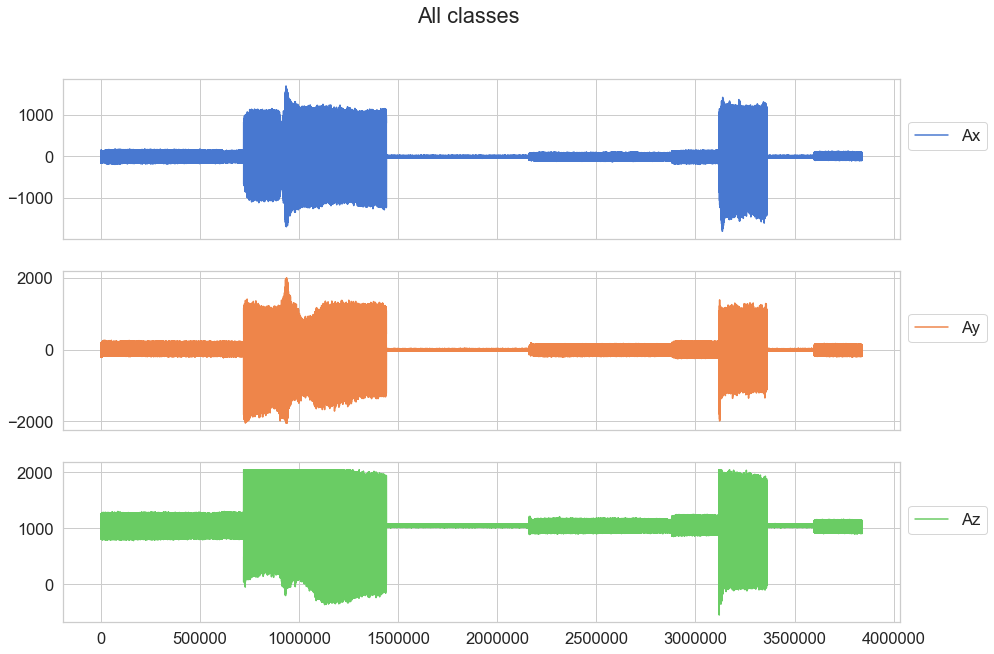

In [6]:
plot_all(ds)

In [7]:
# plot_class(["FAN-CLOG", "FAN-FRICTION", "FAN-OFF", "FAN-ON"], ds)
# plot_class(["FAN-CLOG"], ds)
# plot_class(["FAN-FRICTION"], ds)
# plot_class(["FAN-OFF"], ds)
# plot_class(["FAN-ON"], ds)
# plot_class_interval("FAN-CLOG", ds, 200, 400)
# plot_class_interval("FAN-FRICTION", ds, 200, 400)
# plot_class_interval("FAN-OFF", ds, 200, 400)
# plot_class_interval("FAN-ON", ds, 200, 400)

# 2) Preprocessing

### Normalize the raw data

In [8]:
def normalize_data_new(ds: pd.DataFrame,feats, mean: np.array, std: np.array):
    # feats: list of features to normalize ['Ax', 'Ay', 'Az']
    # (data - mean_data) / std_data
    
    if v1_NORMALIZATION == 1:
        ds[feats] /= SENSOR_ACC_RESOLUTION
    else:    
        ds[feats] = (ds[feats] - mean) / std
        
    return ds


### Split and reshape the dataset to be used as input for model training/validation/test
The data set is split into train and validation

In [9]:
def data_split(ds):
    """
    This function splits the data in 2d subsets (FEED_WINDOW x nb_features).
    """

    in_tensors = []
    cls_list = []
    for i in range(0, len(ds) - FEED_WINDOW_OFST, FEED_WINDOW_OFST):
        isp = i + FEED_WINDOW
        if isp > len(ds): break
        in_tensors.append([ds['Ax'].values[i:isp], ds['Ay'].values[i:isp], ds['Az'].values[i:isp]])
        #cls_list.append(stats.mode(ds['class'][i:isp], keepdims=True)[0][0])
        cls_list.append(ds['class'][i:isp].mode()[0])
    
    return in_tensors, cls_list

def data_reshape(tensors, cls_list):
    """
    This function reshapes the data in 2d subsets (images: FEED_WINDOW x 1 x nb_features).
    """
    reshp_tens = []
    for i in range(np.array(tensors).shape[0]):
        temp = np.asarray(tensors[i], dtype= np.float32).ravel(order='F').reshape(-1, FEED_WINDOW, N_CHANNELS)
        reshp_tens.append(temp.reshape(FEED_WINDOW, 1, N_CHANNELS))

    reshp_tens = np.asarray(reshp_tens, dtype= np.float32)
    labels = np.asarray(cls_list, dtype=np.float32)
    return reshp_tens, labels

In [10]:
ds.columns

Index(['class', 'time[ms]', 'Ax', 'Ay', 'Az', 'filename', 'source'], dtype='object')

In [11]:
# Extract the features from the raw dataset and sort in overlaped segments per class
columns = ['Ax', 'Ay', 'Az', 'class']
feats_norm=['Ax', 'Ay', 'Az'] # list of features to normalise
classes = {'FAN-CLOG':0, 'FAN-FRICTION':1, 'FAN-OFF':2,'FAN-ON':3}

# Split train and validation data
ds_train =ds[ds['source']=='training'].copy()
ds_val = ds[ds['source']=='validation'].copy()
# Normalise train and validation
train_mean = ds_train[columns[:3]].mean().values
train_std = ds_train[columns[:3]].std().values

ds_train = normalize_data_new(ds_train.copy(),feats_norm, train_mean, train_std)
ds_val = normalize_data_new(ds_val.copy(),feats_norm, train_mean, train_std)

ds_train['class']=ds_train['class'].map({'FAN-CLOG':0, 'FAN-FRICTION':1, 'FAN-OFF':2,'FAN-ON':3})
ds_val['class']=ds_val['class'].map({'FAN-CLOG':0, 'FAN-FRICTION':1, 'FAN-OFF':2,'FAN-ON':3})


# Extract the features from the raw dataset and divide them in training and validation set
X_segs_t = []
X_segs_v = []
y_lbls_t = []
y_lbls_v = []


# TRAINING DATA
tr_file_names=list(Counter(ds_train['filename']).keys()) # list of training files names
for f in tr_file_names:
    df=ds_train.loc[ds_train['filename']==f] 
    s, l = data_split(df)
    X_segs_t = X_segs_t + s
    y_lbls_t = y_lbls_t + l

# VALIDATION DATA
val_file_names=list(Counter(ds_val['filename']).keys())  # list of validation files names
for f in val_file_names:
    df=ds_val.loc[ds_val['filename']==f]
    s, l = data_split(df)
    X_segs_v = X_segs_v + s
    y_lbls_v = y_lbls_v + l

# Reshape and assemble the full dataset by each class
X_train, y_train = data_reshape(X_segs_t, y_lbls_t)
X_test, y_test = data_reshape(X_segs_v, y_lbls_v)
X_full = np.concatenate([X_train, X_test])
y_full = np.concatenate([y_train, y_test])

In [12]:
# create an empty file
file_name = os.path.join(OUT_MODELS_FOLDER, "model_configuration.c")   
open(file_name, 'w').close()

# append the raw data to the file
with open(file_name, "a") as file:
    file.write("#include \"model_configuration.h\"\n\n")

    file.write("/* Mean and standard deviation of the dataset used for NN models training */\n")
    file.write("float model_mean[] = {%s};\n"%(', '.join(map(str, train_mean))))
    file.write("float model_std[] = {%s};\n"%(', '.join(map(str, train_std))))       

"Udate model_configuration.c in your application with the generated file that contains mean {} stddev {} values for this dataset.".format(train_mean, train_std)


'Udate model_configuration.c in your application with the generated file that contains mean [-10.423518 0.306346 1044.487773] stddev [262.303698 239.522832 268.370875] values for this dataset.'

In [13]:
print("Full shape:\t", X_full.shape, y_full.shape)
print("Train shape:\t", X_train.shape, y_train.shape)
print("Test shape:\t", X_test.shape, y_test.shape)
print("Train/class:\t", Counter(y_train)[0])
print("Test/class:\t", Counter(y_test)[0])

print("Classes:", N_CLASSES, classes_name)

Full shape:	 (59992, 128, 1, 3) (59992,)
Train shape:	 (44996, 128, 1, 3) (44996,)
Test shape:	 (14996, 128, 1, 3) (14996,)
Train/class:	 11249
Test/class:	 3749
Classes: 4 ['FAN-CLOG', 'FAN-FRICTION', 'FAN-OFF', 'FAN-ON']


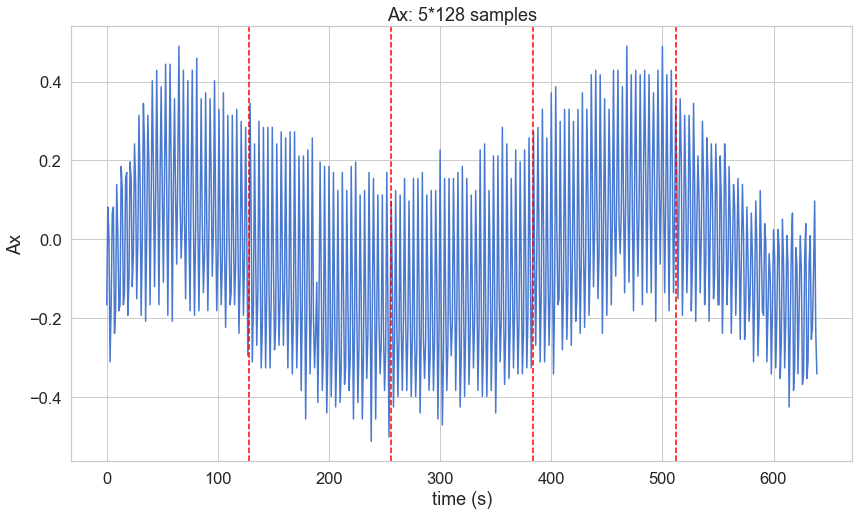

In [14]:
def plot_windows(dt,feat='Ax',wind_size=128,n_windows=5):
    plt.figure()
    plt.plot(dt[feat].iloc[:wind_size*n_windows].reset_index()[feat],color='b')
    for n in range(1,n_windows):
        plt.axvline(x =wind_size*n, color = 'red', ls='--')
    plt.xlabel('time (s)')
    plt.ylabel('Ax')
    plt.title(str('%s: %d*%s samples'%(feat,n_windows,wind_size)))
    plt.plot()
    
window_size=128
n_windows=5
feat='Ax'
plot_windows(ds_val,feat,window_size,n_windows)

### If needed export the dataset to be used in the *c/c++* embedded application 

In [15]:
def dump_sensor_validation_data(name, dataset, raw_samples_count, index_start, index_stop):   
    xp = dataset[['Ax']].values[index_start:index_stop]
    yp = dataset[['Ay']].values[index_start:index_stop]
    zp = dataset[['Az']].values[index_start:index_stop]
    
    raw_line_size = 32
    sensor_data = []
    sensor_data.append(np.reshape(xp, (-1, raw_line_size)))
    sensor_data.append(np.reshape(yp, (-1, raw_line_size)))
    sensor_data.append(np.reshape(zp, (-1, raw_line_size)))

    VALIDATION_DATA_FOLDER = OUT_MODELS_FOLDER + "validation_data/"
    if not os.path.exists(VALIDATION_DATA_FOLDER):
        os.makedirs(VALIDATION_DATA_FOLDER) 
        
    # create an empty file
    file_name = os.path.join(VALIDATION_DATA_FOLDER, name + ".h")   
    open(file_name, 'w').close()

    # append the raw data to the file
    with open(file_name, "a") as file:
        file.write("\n#ifndef " + name + "_H_\n#define " + name + "_H_\n\n")
        file.write("const float " + name + "[" + str(N_CHANNELS) + "][" + str(raw_samples_count) + "] = {\n")

        for i in range(N_CHANNELS):
            file.write("{\n")
            np.savetxt(file, sensor_data[i], fmt='%f', delimiter=',', newline=',\n')
            file.write("},\n")
        file.write("};\n")
        file.write("const unsigned long " + name + "_samples = " + str(raw_samples_count) + ";\n")
        file.write("\n#endif\n")
    print("Done: " + name)

# Export the last validation dataset - vdset_3_vd3* (no of samples = 60000 => 300ms)
dataset_dump_clog = ds_no_norm[ds_no_norm['class'] == 'FAN-CLOG']
dump_sensor_validation_data("vdset_clog", dataset_dump_clog, 6400, -6400, np.shape(dataset_dump_clog)[0])

dataset_dump_friction = ds_no_norm[ds_no_norm['class'] == 'FAN-FRICTION']
dump_sensor_validation_data("vdset_friction", dataset_dump_friction, 6400, -6400, np.shape(dataset_dump_friction)[0])

dataset_dump_off = ds_no_norm[ds_no_norm['class'] == 'FAN-OFF']
dump_sensor_validation_data("vdset_off", dataset_dump_off, 6400, -6400, np.shape(dataset_dump_off)[0])

dataset_dump_on = ds_no_norm[ds_no_norm['class'] == 'FAN-ON']
dump_sensor_validation_data("vdset_on", dataset_dump_on, 6400, -6400, np.shape(dataset_dump_on)[0])

Done: vdset_clog
Done: vdset_friction
Done: vdset_off
Done: vdset_on


# 3) Define the model architecture and the methods for training and evaluation

In [16]:
def model_train_vd(model, trainX, trainy, testX, testy, batch_size, epochs, verbose, callbacks):
    history = model.fit(
        trainX, trainy,
        epochs=epochs,
        batch_size=batch_size,
        shuffle=True,
        callbacks=callbacks,
        validation_data=(testX, testy),
        verbose=verbose,
    )
    return history
def model_evaluate(model, testX, testy, batch_size, verbose):
    loss, acc = model.evaluate(testX, testy, batch_size=batch_size, verbose=verbose)
    print("Model evaluation:")
    print("Accuracy %.5f\tLoss %.5f" % (acc, loss))
    return loss, acc

In [17]:
import tensorflow.lite as tflite
from tensorflow.lite.python.util import convert_bytes_to_c_source

def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(X_full).batch(1).take(100):
        # Model has only one input so each data point has one element.
        yield [input_value]
    
def convert_to_c(tflite_model, file_name, path0):
    from tensorflow.lite.python.util import convert_bytes_to_c_source
    source_text, header_text = convert_bytes_to_c_source(tflite_model, file_name)

    TENSORFLOW_FOLDER = OUT_MODELS_FOLDER + "tensorflow/";

    if not os.path.exists(TENSORFLOW_FOLDER):
        os.makedirs(TENSORFLOW_FOLDER) 

    with  open(os.path.join(TENSORFLOW_FOLDER, file_name + '.h'), 'w') as file:
        file.write(header_text)

    with  open(os.path.join(TENSORFLOW_FOLDER, file_name + '.cpp'), 'w') as file:
        file.write("\n#include \"" + file_name + ".h\"\n")
        file.write(source_text)

def neutron_convert_to_c(model_name_in, model_name_out, path, neutron_folder):
    file = path + "/" + model_name_in + ".h"
    f = open(file, "r")
    lines = f.readlines()
    f.close()

    os.remove(file)
    
    lines_output = []
    for line in lines:
        line = line.replace(model_name_in , model_name_out)
        line = line.replace("model_data" , model_name_out)
        line = line.replace("static const", "const")
        line = line.replace("#define MODEL_NAME" , "#include \"" + model_name_out + ".h\"\n\n#define MODEL_NAME")
        lines_output.append(line.strip())

    TENSORFLOW_NEUTRON_FOLDER = path + neutron_folder
    if not os.path.exists(TENSORFLOW_NEUTRON_FOLDER):
        os.makedirs(TENSORFLOW_NEUTRON_FOLDER)

    f = open(TENSORFLOW_NEUTRON_FOLDER + model_name_out + ".cpp", "w")
    f.write("\n".join(lines_output))
    f.close()

def save_model(model, name, path0 = OUT_MODELS_FOLDER, save = 1):
    model_name_keras = name + ".h5"
    model_name_tflite = name + ".tflite"
    model_name_tflite_quant = name + "_quant.tflite"
    
    if not os.path.exists(path0):
        os.makedirs(path0)     
    
    # store the keras model
    print("Save keras model")
    model.save(path0 +'/' + model_name_keras)

    # convert keras model into tf lite model
    print("Convert and save tf lite model")
    converter = tflite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()

    # convert keras model into quantized tf lite model
    print("Convert and save tf lite model - quantized")    
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = representative_data_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

    tflite_model_quant = converter.convert()

    # store the tf lite models
    open(path0 + model_name_tflite, "wb").write(tflite_model)
    open(path0 + model_name_tflite_quant, "wb").write(tflite_model_quant)
    
    # convert to C source code and store it
    source_file = "tensorflow_" + name
    source_file_quant = "tensorflow_" + name + "_quant"
    convert_to_c(tflite_model, source_file, path0)
    convert_to_c(tflite_model_quant, source_file_quant, path0)

    if GENERATE_GLOW_BUNDLE_EN:
             
        # generate the Glow bundles
        print("Generate the Glow bundles")
   
        GLOW_FOLDER = OUT_MODELS_FOLDER + "glow/";

        if not os.path.exists(GLOW_FOLDER):
            os.makedirs(GLOW_FOLDER) 
        
        entry_glow = "glow_" + name
        entry_glow_quant = "glow_" + name + "_quant"
        
        # generate Glow bundles for ARM Cortex-M7 target
        !C:\nxp\Glow\bin\model-compiler.exe -model=models/$model_name_tflite -emit-bundle=models/glow/cortex_m7/ -backend=CPU -target=arm -mcpu=cortex-m7 -float-abi=hard -use-cmsis -main-entry-name=$entry_glow
        !C:\nxp\Glow\bin\model-compiler.exe -model=models/$model_name_tflite_quant -emit-bundle=models/glow/cortex_m7/ -backend=CPU -target=arm -mcpu=cortex-m7 -float-abi=hard -use-cmsis -main-entry-name=$entry_glow_quant
        
        # generate Glow bundles for ARM Cortex-M33 target
        !C:\nxp\Glow\bin\model-compiler.exe -model=models/$model_name_tflite -emit-bundle=models/glow/cortex_m33/ -backend=CPU -target=arm -mcpu=cortex-m33 -float-abi=hard -use-cmsis -main-entry-name=$entry_glow
        !C:\nxp\Glow\bin\model-compiler.exe -model=models/$model_name_tflite_quant -emit-bundle=models/glow/cortex_m33/ -backend=CPU -target=arm -mcpu=cortex-m33 -float-abi=hard -use-cmsis -main-entry-name=$entry_glow_quant

    if GENERATE_NEUTRON_BUNDLE_EN:
        model_name_tflite_quant_neutron = name + "_quant_mcxn94x_neutron_v120"
        model_name_tflite_quant_neutron_ext = model_name_tflite_quant_neutron + ".tflite"
        
        neutron_out = !C:\nxp\eIQ_Toolkit_v1.10.0\bin\neutron-converter\v1.2.0\neutron-converter.exe --input=models/$model_name_tflite_quant --output=models/$model_name_tflite_quant_neutron_ext --target={'mcxn94x'} --dump-header-file

        neutron_convert_to_c(model_name_tflite_quant_neutron, "tensorflow_" + name + "_quant_neutron", path0, "tensorflow/mcxn94x_neutron_v120/")
        
    print("Done!")

## 3.1) Define differents models architectures


In [18]:
import numpy as np
import tensorflow as tf
from keras import Input, Model
from keras.layers import Flatten, Dense, ReLU, BatchNormalization, Conv2D, Add, \
    AveragePooling2D, Conv1D, AveragePooling1D
from keras.regularizers import l2
from tensorflow import Tensor

tf.random.set_seed(RANDOM_SEED)

print("Tensorflow - is_built_with_cuda:", tf.test.is_built_with_cuda())
print("Tensorflow - PhysicalDevice:", tf.config.list_physical_devices())

Tensorflow - is_built_with_cuda: True
Tensorflow - PhysicalDevice: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


### 3.1.1) CNN Architecture

In [19]:
def model_cnn(window_size: int = 128, n_fields: int = 3, n_classes: int = 4):
    from keras.regularizers import l2

    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(window_size, 1, n_fields), name='acceleration'))
    model.add(tf.keras.layers.Conv2D(8, (4, 1), activation='relu'))
    model.add(tf.keras.layers.Conv2D(8, (4, 1), activation='relu'))

    model.add(tf.keras.layers.Dropout(0.5))

    model.add(tf.keras.layers.MaxPool2D((8, 1), padding='valid'))
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(64, kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4), activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(32, kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4), activation='relu'))
    model.add(tf.keras.layers.Dropout(0.5))
    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

def model_lcnn(window_size: int = 128, n_fields: int = 3, n_classes: int = 4):
    model = tf.keras.Sequential()
    model.add(tf.keras.Input(shape=(window_size, 1, n_fields), name='acceleration'))
    model.add(tf.keras.layers.Conv2D(8, (4, 1), activation='relu'))

    model.add(tf.keras.layers.Dropout(0.2))

    model.add(tf.keras.layers.MaxPool2D((8, 1), padding='valid'))
    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(16, kernel_regularizer=l2(1e-4), bias_regularizer=l2(1e-4), activation='relu'))

    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

### 3.1.2) MLP Architecture

In [20]:
def model_mlp(window_size: int = 128, n_fields: int = 3, n_classes: int = 4):
    input_layer = Input(shape=(window_size, 1, n_fields))
    flat = Flatten()(input_layer)
    middle = Dense(16, activation='relu')(flat)
    outputs = Dense(n_classes, activation='softmax')(middle)
    model = Model(inputs=input_layer, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

### 3.1.3) Resnet architecture

In [21]:
def model_lresnet(window_size: int = 128, n_fields: int = 3, n_classes: int = 4):
    def relu_bn(inp: Tensor) -> Tensor:
        relu = ReLU()(inp)
        bn = BatchNormalization(axis=3, trainable=False)(relu)
        return bn

    def residual_block(x: Tensor, filters: int, kernel_size: int = 3) -> Tensor:
        y = Conv2D(kernel_size=(kernel_size, 1),
                   strides=1,
                   filters=filters,
                   padding="same")(x)
        y = relu_bn(y)
        y = Conv2D(kernel_size=(kernel_size, 1),
                   strides=1,
                   filters=filters,
                   padding="same")(y)

        out = Add()([x, y])
        out = relu_bn(out)
        return out

    inputs = Input(shape=(window_size, 1, n_fields))  # Input(shape=self.valid_shape)
    num_filters = 16

    t = BatchNormalization(axis=3, trainable=False)(inputs)
    t = Conv2D(kernel_size=(3, 1),
               strides=1,
               filters=num_filters,
               padding="same")(t)
    t = relu_bn(t)
    # Modify this block in order to add new convolutional blocks
    t = residual_block(t, filters=num_filters)
    if window_size != 1 and n_fields != 1:
        t = AveragePooling2D((2, 1))(t)
    t = Flatten()(t)
    outputs = Dense(n_classes, activation='softmax')(t)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)

    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

## 3.2) Training all the models

In [22]:
# Define models to be trained, evaluated and exported
available_models = {
    "model_cnn": model_cnn,
    "model_lcnn": model_lcnn,
    "model_mlp": model_mlp,
    "model_lresnet": model_lresnet
}

In [23]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)

EPOCHS = 100
BATCH_SIZE = 32

callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=5, verbose=1)]

results_models=pd.DataFrame(data=[], index=["tr-loss","tr-acc","vd-loss",'vd-acc',"tl-loss","tl-acc"])

for f_name in available_models:
    print('\r\nModel \'{0}\' is running be patient!'.format(f_name))
    model_path0 = os.path.join(OUT_MODELS_FOLDER, f_name)
    model = available_models[f_name](FEED_WINDOW, N_CHANNELS, N_CLASSES)
    model_train_vd(model, X_train, y_train,X_test, y_test, BATCH_SIZE, EPOCHS, 1, callbacks)
    metr_val = model.evaluate(X_test, y_test)
    metr_tr = model.evaluate(X_train, y_train)
    metr_full = model.evaluate(X_full, y_full)
    results_models[f_name] = list(np.round(metr_tr,4))+list(np.round(metr_val,4))+list(np.round(metr_full,4))
    save_model(model, f_name, OUT_MODELS_FOLDER)
    print('\r\nModel \'{0}\'  has a validation acc= {1}\r\n'.format(f_name,np.round(metr_val,4)[1]))


Model 'model_cnn' is running be patient!
Epoch 1/100
1407/1407 [==============================] - 15s 9ms/step - loss: 1.0775 - accuracy: 0.5514 - val_loss: 0.6483 - val_accuracy: 0.9929
Epoch 2/100
1407/1407 [==============================] - 13s 9ms/step - loss: 0.3826 - accuracy: 0.8823 - val_loss: 0.1518 - val_accuracy: 0.9994
Epoch 3/100
1407/1407 [==============================] - 13s 9ms/step - loss: 0.1489 - accuracy: 0.9625 - val_loss: 0.0586 - val_accuracy: 0.9994
Epoch 4/100
1407/1407 [==============================] - 12s 9ms/step - loss: 0.0911 - accuracy: 0.9791 - val_loss: 0.0354 - val_accuracy: 0.9993
Epoch 5/100
1407/1407 [==============================] - 13s 9ms/step - loss: 0.0667 - accuracy: 0.9849 - val_loss: 0.0251 - val_accuracy: 0.9993
Epoch 6/100
1407/1407 [==============================] - 13s 9ms/step - loss: 0.0504 - accuracy: 0.9900 - val_loss: 0.0229 - val_accuracy: 0.9993
Epoch 7/100
1407/1407 [==============================] - 13s 9ms/step - loss: 0.04

1407/1407 [==============================] - 13s 9ms/step - loss: 0.0068 - accuracy: 0.9990 - val_loss: 0.0066 - val_accuracy: 0.9995
Epoch 57/100
1407/1407 [==============================] - 13s 9ms/step - loss: 0.0063 - accuracy: 0.9993 - val_loss: 0.0067 - val_accuracy: 0.9995
Epoch 58/100
1407/1407 [==============================] - 13s 9ms/step - loss: 0.0064 - accuracy: 0.9991 - val_loss: 0.0063 - val_accuracy: 0.9995
Epoch 59/100
1407/1407 [==============================] - 13s 10ms/step - loss: 0.0060 - accuracy: 0.9992 - val_loss: 0.0063 - val_accuracy: 0.9995
Epoch 60/100
1407/1407 [==============================] - 13s 9ms/step - loss: 0.0061 - accuracy: 0.9992 - val_loss: 0.0062 - val_accuracy: 0.9995
Epoch 61/100
1407/1407 [==============================] - 13s 9ms/step - loss: 0.0059 - accuracy: 0.9992 - val_loss: 0.0055 - val_accuracy: 0.9995
Epoch 62/100
1407/1407 [==============================] - 13s 9ms/step - loss: 0.0056 - accuracy: 0.9994 - val_loss: 0.0060 - val_

INFO:tensorflow:Assets written to: C:\Users\nxa17614\AppData\Local\Temp\1\tmpkjn8z0q1\assets


Generate the Glow bundles


I0315 11:59:39.283713 10060 HostManager.cpp:239] Destroying host manager...
I0315 11:59:39.695508 21936 HostManager.cpp:239] Destroying host manager...
I0315 11:59:40.191583 28012 HostManager.cpp:239] Destroying host manager...
I0315 12:06:50.457417 19296 HostManager.cpp:239] Destroying host manager...


Done!

Model 'model_cnn'  has a validation acc= 0.9995


Model 'model_lcnn' is running be patient!
Epoch 1/100
1407/1407 [==============================] - 8s 5ms/step - loss: 1.0486 - accuracy: 0.3780 - val_loss: 0.8112 - val_accuracy: 0.7207
Epoch 2/100
1407/1407 [==============================] - 9s 6ms/step - loss: 0.5559 - accuracy: 0.9321 - val_loss: 0.3637 - val_accuracy: 0.9991
Epoch 3/100
1407/1407 [==============================] - 9s 6ms/step - loss: 0.1565 - accuracy: 0.9986 - val_loss: 0.1132 - val_accuracy: 0.9994
Epoch 4/100
1407/1407 [==============================] - 9s 6ms/step - loss: 0.0405 - accuracy: 0.9992 - val_loss: 0.0476 - val_accuracy: 0.9994
Epoch 5/100
1407/1407 [==============================] - 9s 6ms/step - loss: 0.0173 - accuracy: 0.9994 - val_loss: 0.0266 - val_accuracy: 0.9994
Epoch 6/100
1407/1407 [==============================] - 9s 7ms/step - loss: 0.0110 - accuracy: 0.9995 - val_loss: 0.0188 - val_accuracy: 0.9993
Epoch 7/100
1407/1407 [========

INFO:tensorflow:Assets written to: C:\Users\nxa17614\AppData\Local\Temp\1\tmpacwpnhih\assets


Convert and save tf lite model - quantized
INFO:tensorflow:Assets written to: C:\Users\nxa17614\AppData\Local\Temp\1\tmpvwzalc3q\assets


INFO:tensorflow:Assets written to: C:\Users\nxa17614\AppData\Local\Temp\1\tmpvwzalc3q\assets


Generate the Glow bundles


I0315 12:11:40.317673 26980 HostManager.cpp:239] Destroying host manager...
I0315 12:11:40.784576 24748 HostManager.cpp:239] Destroying host manager...
I0315 12:11:41.295223 13868 HostManager.cpp:239] Destroying host manager...
I0315 12:11:41.763698 31820 HostManager.cpp:239] Destroying host manager...


Done!

Model 'model_lcnn'  has a validation acc= 0.9988


Model 'model_mlp' is running be patient!
Epoch 1/100
1407/1407 [==============================] - 5s 3ms/step - loss: 1.4831 - accuracy: 0.2837 - val_loss: 1.3645 - val_accuracy: 0.2623
Epoch 2/100
1407/1407 [==============================] - 4s 3ms/step - loss: 1.0142 - accuracy: 0.5584 - val_loss: 1.1398 - val_accuracy: 0.4466
Epoch 3/100
1407/1407 [==============================] - 4s 3ms/step - loss: 0.7853 - accuracy: 0.6918 - val_loss: 1.0205 - val_accuracy: 0.5338
Epoch 4/100
1407/1407 [==============================] - 4s 3ms/step - loss: 0.6359 - accuracy: 0.7121 - val_loss: 0.9432 - val_accuracy: 0.5326
Epoch 5/100
1407/1407 [==============================] - 4s 3ms/step - loss: 0.5266 - accuracy: 0.7754 - val_loss: 0.8907 - val_accuracy: 0.7051
Epoch 6/100
1407/1407 [==============================] - 4s 3ms/step - loss: 0.4376 - accuracy: 0.9443 - val_loss: 0.8545 - val_accuracy: 0.7235
Epoch 7/100
1407/1407 [========

INFO:tensorflow:Assets written to: C:\Users\nxa17614\AppData\Local\Temp\1\tmp7wihfu33\assets


Convert and save tf lite model - quantized
INFO:tensorflow:Assets written to: C:\Users\nxa17614\AppData\Local\Temp\1\tmpc5w0x6m4\assets


INFO:tensorflow:Assets written to: C:\Users\nxa17614\AppData\Local\Temp\1\tmpc5w0x6m4\assets


Generate the Glow bundles


I0315 12:14:05.218063 25024 HostManager.cpp:239] Destroying host manager...
I0315 12:14:05.662855 26112 HostManager.cpp:239] Destroying host manager...
I0315 12:14:06.213881 27280 HostManager.cpp:239] Destroying host manager...
I0315 12:14:06.642338 26052 HostManager.cpp:239] Destroying host manager...


Done!

Model 'model_mlp'  has a validation acc= 0.8013


Model 'model_lresnet' is running be patient!
Epoch 1/100
1407/1407 [==============================] - 22s 15ms/step - loss: 0.1297 - accuracy: 0.9381 - val_loss: 0.0113 - val_accuracy: 0.9978
Epoch 2/100
1407/1407 [==============================] - 21s 15ms/step - loss: 6.3354e-04 - accuracy: 1.0000 - val_loss: 0.0066 - val_accuracy: 0.9985
Epoch 3/100
1407/1407 [==============================] - 21s 15ms/step - loss: 6.3248e-04 - accuracy: 0.9999 - val_loss: 0.0135 - val_accuracy: 0.9965
Epoch 4/100
1407/1407 [==============================] - 21s 15ms/step - loss: 2.1898e-04 - accuracy: 1.0000 - val_loss: 0.0080 - val_accuracy: 0.9978
Epoch 5/100
1407/1407 [==============================] - 21s 15ms/step - loss: 8.6098e-05 - accuracy: 1.0000 - val_loss: 0.0061 - val_accuracy: 0.9985
Epoch 6/100
1407/1407 [==============================] - 21s 15ms/step - loss: 2.6611e-05 - accuracy: 1.0000 - val_loss: 0.0062 - val_accuracy: 0.9

C:\Users\nxa17614\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: C:\Users\nxa17614\AppData\Local\Temp\1\tmpmbbg6an0\assets


INFO:tensorflow:Assets written to: C:\Users\nxa17614\AppData\Local\Temp\1\tmpmbbg6an0\assets
C:\Users\nxa17614\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Convert and save tf lite model - quantized
INFO:tensorflow:Assets written to: C:\Users\nxa17614\AppData\Local\Temp\1\tmpwv0qf3xg\assets


INFO:tensorflow:Assets written to: C:\Users\nxa17614\AppData\Local\Temp\1\tmpwv0qf3xg\assets
C:\Users\nxa17614\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Generate the Glow bundles


I0315 12:19:58.611865 30832 HostManager.cpp:239] Destroying host manager...
I0315 12:19:59.146518  6688 HostManager.cpp:239] Destroying host manager...
I0315 12:19:59.878198 30196 HostManager.cpp:239] Destroying host manager...


Done!

Model 'model_lresnet'  has a validation acc= 0.9997



I0315 12:20:00.464607 30700 HostManager.cpp:239] Destroying host manager...


In [24]:
results_models.T

,tr-loss,tr-acc,vd-loss,vd-acc,tl-loss,tl-acc
model_cnn,0.0019,1.0000,0.0043,0.9995,0.0025,0.9999
model_lcnn,0.0023,1.0000,0.0078,0.9988,0.0037,0.9997
model_mlp,0.0097,0.9979,0.5539,0.8013,0.1457,0.9488
model_lresnet,0.0000,1.0000,0.0027,0.9997,0.0007,0.9999


## 3.3) Evaluation steps: 

### Evaluate the trained model through confusion matrixes and history plot

In [25]:
def confusion_matrix_plot(y_true, y_pred):
    clslb = []
    for class_type in classes_name:
        clslb.append(class_type)
    cf_mat = metrics.confusion_matrix(y_true, y_pred, labels=[0,1,2,3])
    print("Accuracy %.5f" % (np.trace(cf_mat)/np.sum(cf_mat)))
    
    plt.figure(figsize=(9, 7))
    sns.heatmap(cf_mat, xticklabels=clslb, yticklabels=clslb, annot=True, fmt="d", annot_kws={'va':'top'}, cbar=False);
    sns.heatmap(cf_mat/np.sum(cf_mat), xticklabels=clslb, yticklabels=clslb, annot=True, fmt=".1%", annot_kws={'va':'bottom'});
    plt.title("Confusion matrix")
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show();    
    
def confusion_matrix(model, X, y):
    y_pred = model.predict(X)
    #max_test = np.argmax(y, axis=1)
    max_predictions = np.argmax(y_pred, axis=1)
    confusion_matrix_plot(y, max_predictions)
    
def plot_train(history):
    fig, ax1 = plt.subplots()
    ax1.plot(history.history['accuracy'], color='red', label='accuracy')
    ax1.set_ylabel('accuracy')
    ax1.legend(loc="lower left")

    ax2 = ax1.twinx()
    ax2.plot(history.history['loss'], color='blue', label='loss')
    ax2.set_ylabel('loss')
    ax2.legend(loc="upper left")

    plt.show()
def plot_train_metric(history, acc_loss):
    if acc_loss == "accuracy":
        plt.title("Accuracy")
        train = np.array(history.history['accuracy'])
        test = np.array(history.history['val_accuracy'])
    else:
        plt.title("Loss")
        train = np.array(history.history['loss'])
        test = np.array(history.history['val_loss'])                             

    plt.plot(train, "g-", label="Train")
    plt.plot(test, "r--", label="Test")

    plt.legend(loc='lower left', shadow=True)
    plt.ylabel('Training Progress')
    plt.xlabel('Training Epoch')
    plt.show()
    
def plot_train_session(history):
    # plt.figure(figsize=(20, 10))
    plt.plot(np.array(history.history['accuracy']), "r-", label="Train accuracy")
    plt.plot(np.array(history.history['loss']), "b-", label="Train loss")
    plt.plot(np.array(history.history['val_accuracy']), "g--", label="Test accuracy")
    plt.plot(np.array(history.history['val_loss']), "m--", label="Test loss")
    plt.title("Training session's progress over iterations")
    plt.legend(loc='center right', shadow=True)
    plt.ylabel('Training Progress')
    plt.xlabel('Training Epoch')
    plt.show()

# Import and evaluate a File System (Keras) Model
def evaluate_fs_model_keras(fs_model_name, X_set, y_set, batch_size):
    fs_model_keras = tf.keras.models.load_model(fs_model_name)
    loss, acc = model_evaluate(fs_model_keras, X_set, y_set, batch_size, 1)
    confusion_matrix(fs_model_keras, X_set, y_set)
    return fs_model_keras


# Import and evaluate a File System (TF Lite) Model    
def evaluate_fs_model_tflite(fs_model_name, X_set, y_set):
    # Load TFLite model and allocate tensors
    interpreter = tf.lite.Interpreter(model_path=fs_model_name, num_threads=1)
    interpreter.allocate_tensors()

    # Get input and output tensors
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Test model on random input data
    input_shape = input_details[0]['shape']

    y_pred_tflite_fs = []
    start = time.time()
    for i in range(X_set.shape[0]):
        input_data = X_set[i].reshape(input_shape)
        interpreter.set_tensor(input_details[0]['index'], input_data)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_details[0]['index'])
        y_pred_tflite_fs.append(output_data.reshape(-1))
    dur = time.time() - start
    print(f"Inference duration: {dur}")
    y_pred = np.argmax(y_pred_tflite_fs, axis=1)
    #y_set=np.argmax(y_set, axis=1)
    cf_mat = metrics.confusion_matrix(y_set, y_pred, labels=[0,1,2,3])
    test_acc=np.trace(cf_mat)/np.sum(cf_mat)
    #test_loss=np.mean((y_set-y_pred)**2)
    return [test_acc,dur]

### Import and evaluate from filesystem a previously exported model

469/469 [==============================] - 2s 4ms/step - loss: 0.0043 - accuracy: 0.9995
Model evaluation:
Accuracy 0.99953	Loss 0.00433
Accuracy 0.99953


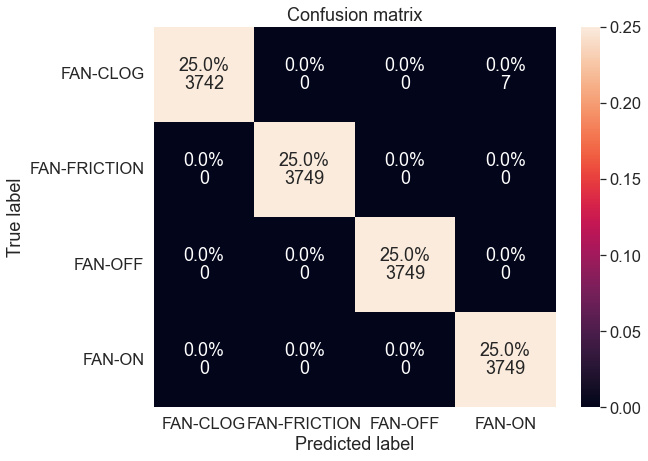

In [26]:
fs_model_name="model_cnn.h5"
evaluate_fs_model_keras(OUT_MODELS_FOLDER + fs_model_name, X_test, y_test, BATCH_SIZE)

# 4) Evaluate saved quantized models on test data

In [27]:
Quant_results_models=pd.DataFrame(data=[], index=["test acc",'test inf duration'])

for f_name in available_models:
    print('model {0} is running be patient!'.format(f_name))
    model_path0 =  os.path.join(OUT_MODELS_FOLDER, f_name)    
    model = available_models[f_name](FEED_WINDOW, N_CHANNELS, N_CLASSES)      
    quant_test = evaluate_fs_model_tflite(f"{model_path0}_quant.tflite", X_test, y_test)
    tflite_test = evaluate_fs_model_tflite(f"{model_path0}.tflite", X_test, y_test)
    Quant_results_models[f_name+'_quant']=quant_test
    Quant_results_models[f_name]= tflite_test
#Quant_results_models.T.to_excel('*/ml-state-monitor/quantized_performancesMans.xlsx')

model model_cnn is running be patient!
Inference duration: 28.732322931289673
Inference duration: 0.5364179611206055
model model_lcnn is running be patient!
Inference duration: 7.644253730773926
Inference duration: 0.3885314464569092
model model_mlp is running be patient!
Inference duration: 4.816487789154053
Inference duration: 0.2892885208129883
model model_lresnet is running be patient!
Inference duration: 105.85536170005798
Inference duration: 1.1385324001312256


In [28]:
#Note: Inference duration for quantized models may be suboptimal on x86
Quant_results_models.T

,test acc,test inf duration
model_cnn_quant,0.991198,28.732323
model_cnn,0.999533,0.536418
model_lcnn_quant,0.997466,7.644254
model_lcnn,0.998800,0.388531
model_mlp_quant,0.701654,4.816488
model_mlp,0.801347,0.289289
model_lresnet_quant,0.999600,105.855362
model_lresnet,0.999667,1.138532
